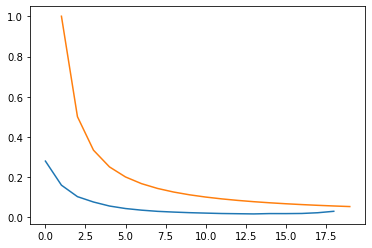

49      , -1853.59    , array([ 1.82758    ,  0.717392   ])
50      , -1856.97    , array([ 1.82941    ,  0.717392   ])
51      , -1853.61    , array([ 1.82758    ,  0.71811    ])
52      , -1503.86    , array([ 0.665655   ,  0.712359   ])
53      , -1502.49    , array([ 0.666321   ,  0.712359   ])
54      , -1503.18    , array([ 0.665655   ,  0.713072   ])
55      , -1063.85    , array([ 0.535124   ,  3.1325     ])
56      , -1063.86    , array([ 0.53566    ,  3.1325     ])
57      , -1063.85    , array([ 0.535124   ,  3.13564    ])
58      , -1063.79    , array([ 0.532225   ,  3.19215    ])
59      , -1063.79    , array([ 0.532757   ,  3.19215    ])
60      , -1063.78    , array([ 0.532225   ,  3.19535    ])
61      , -1063.67    , array([ 0.525891   ,  3.32753    ])
62      , -1063.67    , array([ 0.526417   ,  3.32753    ])
63      , -1063.67    , array([ 0.525891   ,  3.33086    ])
64      , -1063.53    , array([ 0.511756   ,  3.65719    ])
65      , -1063.53    , array([ 0.512268

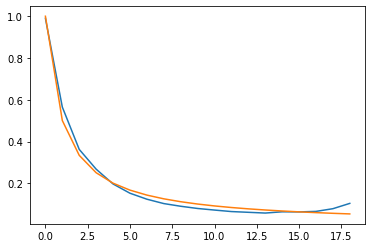

0.4064936978033455 8.122266762917993
0.01146647227457138 8.122266762917993 38842.072630417155 95553.93562142817 0.4064936978033455 4.061133381458997
0.010873590927031475


In [2]:
#input sfs, corrected raisd file, file prefix  

#fit demographic model
#print obs and exp sfs to figure
#print prefix, parameters, etc. to data file for alter concactenation
#filter raisd file for outliers



import dadi
from dadi import Numerics, PhiManip, Integration, Spectrum
import numpy as np
import os
import matplotlib.pyplot as plt
import dadi.DFE as DFE


def two_epoch(params, ns, pts):
    """
    Instantaneous size change some time ago.

    params = (nu,T)
    ns = (n1,)

    nu: Ratio of contemporary to ancient population size
    T: Time in the past at which size change happened (in units of 2*Na 
       generations) 
    n1: Number of samples in resulting Spectrum
    pts: Number of grid points to use in integration.
    """
    
    nu,T = params

    xx = Numerics.default_grid(pts)
    phi = PhiManip.phi_1D(xx)
    
    phi = Integration.one_pop(phi, xx, T, nu)

    fs = Spectrum.from_phi(phi, ns, (xx,))
    return fs


def three_epoch(params, ns, pts):
    """
    params = (nuB,nuF,TB,TF)
    ns = (n1,)

    nuB: Ratio of bottleneck population size to ancient pop size
    nuF: Ratio of contemporary to ancient pop size
    TB: Length of bottleneck (in units of 2*Na generations) 
    TF: Time since bottleneck recovery (in units of 2*Na generations) 

    n1: Number of samples in resulting Spectrum
    pts: Number of grid points to use in integration.
    """
    nuB,nuF,TB,TF = params

    xx = Numerics.default_grid(pts)
    phi = PhiManip.phi_1D(xx)

    phi = Integration.one_pop(phi, xx, TB, nuB)
    phi = Integration.one_pop(phi, xx, TF, nuF)

    fs = Spectrum.from_phi(phi, ns, (xx,))
    return fs

#with open("../data/angsd_pi/v5--Teo--random1_Palmar_Chico.sfs") as f:
#with open("../data/angsd_sfs/v5--Teo--Amatlan_de_Canas_fold4_AT,AG,AC,TA,TG,TC,GA,GT,GC,CA,CT,CG_sfs.txt") as f:
#with open("../data/angsd_sfs/v5--Teo--Palmar_Chico_fold4_AT,AG,AC,TA,TG,TC,GA,GT,GC,CA,CT,CG_sfs.txt") as f:    
#with open("../data/angsd_sfs/v5--Teo--random2_Palmar_Chico_fold4_AT,AG,AC,TA,TG,TC,GA,GT,GC,CA,CT,CG_sfs.txt") as f:        
with open("../data/angsd_sfs/v5--Teo--Los_Guajes_fold4_AT,AG,AC,TA,TG,TC,GA,GT,GC,CA,CT,CG_sfs.txt") as f:        
    sfs = f.readlines()[0].split()
    sfs = [float(s) for s in sfs]


fs = dadi.Spectrum(np.round(sfs, 0))
#sel_fs = dadi.Spectrum(np.round(sel_sfs, 0))

params = (1, 1)
ns = fs.sample_sizes
pts = [200]

my_extrap_func = Numerics.make_extrap_log_func(two_epoch)
model = my_extrap_func(params, ns, pts)

plt.plot(sfs[1:-1]/np.sum(sfs[1:-1]))
plt.plot(my_extrap_func(params, ns, pts))
plt.show()

ll_model = dadi.Inference.ll_multinom(model, fs)
theta = dadi.Inference.optimal_sfs_scaling(model, fs)

lower_bound, upper_bound = [1e-1, 1e-1], [1e1, 1e1]
p0 = dadi.Misc.perturb_params(params, lower_bound=lower_bound, upper_bound=upper_bound)
dadi_opt = dadi.Inference.optimize_log(p0, fs, my_extrap_func, pts, verbose=1, maxiter=5000, lower_bound=lower_bound, upper_bound=upper_bound)

#p0 = dadi.Misc.perturb_params(params)
#dadi_opt = dadi.Inference.optimize_log(p0, fs, my_extrap_func, pts, verbose=1, maxiter=1000)

plt.plot(sfs[1:-1]/theta)
plt.plot(my_extrap_func(params, ns, pts)[1:-1])
plt.show()

ns = ns
reps = 10
bps = 10000

mu = 3e-8
nu, T = dadi_opt

print(f"{nu} {T}")
theta_sc = theta / sum(sfs)
#N_0 = theta_sc/(4*mu)
#N_anc = N_0 / nu
N_anc = theta_sc/(4*mu)
N_0 = nu * N_anc
c = 1.6e-8
print(f"{theta_sc} {T} {N_0} {N_anc} {nu} {T/2}")
print(fs.pi()/sum(sfs))

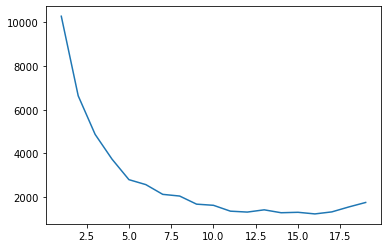

In [22]:
#plt.plot(sfs[1:-1])

#print(fs.pi(), sum(fs[1:-1]))
#print(fs.pi()/sum(sfs))

fs.sample_sizes
plt.plot(fs)

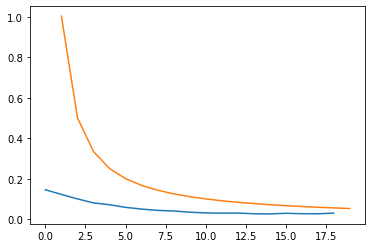

10      , -5350.5     , array([ 0.867731   ,  1.31066    ,  1.41003    ,  0.674047   ])
11      , -5345.79    , array([ 0.8686     ,  1.31066    ,  1.41003    ,  0.674047   ])
12      , -5357.08    , array([ 0.867731   ,  1.31197    ,  1.41003    ,  0.674047   ])
13      , -5350.87    , array([ 0.867731   ,  1.31066    ,  1.41144    ,  0.674047   ])
14      , -5350.04    , array([ 0.867731   ,  1.31066    ,  1.41003    ,  0.674722   ])
15      , -1368.66    , array([ 1.55971    ,  0.57783    ,  1.3463     ,  0.71427    ])
16      , -1367.81    , array([ 1.56127    ,  0.57783    ,  1.3463     ,  0.71427    ])
17      , -1369.3     , array([ 1.55971    ,  0.578408   ,  1.3463     ,  0.71427    ])
18      , -1368.39    , array([ 1.55971    ,  0.57783    ,  1.34765    ,  0.71427    ])
19      , -1369.68    , array([ 1.55971    ,  0.57783    ,  1.3463     ,  0.714984   ])
20      , -22057.2    , array([ 13.2366    ,  0.484797   ,  6.37271    ,  0.00269036 ])
21      , -22079.2    , array([ 

151     , -221.104    , array([ 0.545459   ,  0.0180282  ,  0.863401   ,  0.00216019 ])
152     , -221.123    , array([ 0.544914   ,  0.0180462  ,  0.863401   ,  0.00216019 ])
153     , -221.109    , array([ 0.544914   ,  0.0180282  ,  0.864265   ,  0.00216019 ])
154     , -221.046    , array([ 0.544914   ,  0.0180282  ,  0.863401   ,  0.00216236 ])
155     , -217.564    , array([ 0.504683   ,  0.0132818  ,  0.858195   ,  0.00156239 ])
156     , -217.577    , array([ 0.505188   ,  0.0132818  ,  0.858195   ,  0.00156239 ])
157     , -217.591    , array([ 0.504683   ,  0.0132951  ,  0.858195   ,  0.00156239 ])
158     , -217.584    , array([ 0.504683   ,  0.0132818  ,  0.859053   ,  0.00156239 ])
159     , -217.545    , array([ 0.504683   ,  0.0132818  ,  0.858195   ,  0.00156396 ])
160     , -213.637    , array([ 0.437775   ,  0.0068295  ,  0.842472   ,  0.00077118 ])
161     , -213.64     , array([ 0.438213   ,  0.0068295  ,  0.842472   ,  0.00077118 ])
162     , -213.668    , array([ 

255     , -208.748    , array([ 0.152971   ,  4.53424e-07,  0.520163   ,  4.94778e-08])
256     , -208.711    , array([ 0.153124   ,  4.53424e-07,  0.520163   ,  4.94778e-08])
257     , -208.785    , array([ 0.152971   ,  4.53878e-07,  0.520163   ,  4.94778e-08])
258     , -208.808    , array([ 0.152971   ,  4.53424e-07,  0.520683   ,  4.94778e-08])
259     , -208.713    , array([ 0.152971   ,  4.53424e-07,  0.520163   ,  4.95273e-08])
260     , -209.175    , array([ 0.116995   ,  2.01199e-08,  0.437287   ,  2.19926e-09])
261     , -209.113    , array([ 0.117112   ,  2.01199e-08,  0.437287   ,  2.19926e-09])
262     , -209.223    , array([ 0.116995   ,  2.014e-08  ,  0.437287   ,  2.19926e-09])
263     , -209.267    , array([ 0.116995   ,  2.01199e-08,  0.437725   ,  2.19926e-09])
264     , -209.128    , array([ 0.116995   ,  2.01199e-08,  0.437287   ,  2.20146e-09])
265     , -208.752    , array([ 0.144767   ,  2.38975e-07,  0.501929   ,  2.60862e-08])
266     , -208.713    , array([ 

359     , -208.71     , array([ 0.149505   ,  3.47412e-07,  0.512502   ,  3.79531e-08])
360     , -208.745    , array([ 0.149505   ,  3.47405e-07,  0.512501   ,  3.79145e-08])
361     , -208.707    , array([ 0.149654   ,  3.47405e-07,  0.512501   ,  3.79145e-08])
362     , -208.782    , array([ 0.149505   ,  3.47753e-07,  0.512501   ,  3.79145e-08])
363     , -208.806    , array([ 0.149505   ,  3.47405e-07,  0.513014   ,  3.79145e-08])
364     , -208.71     , array([ 0.149505   ,  3.47405e-07,  0.512501   ,  3.79525e-08])
365     , -208.745    , array([ 0.149504   ,  3.47401e-07,  0.512501   ,  3.7914e-08 ])
366     , -208.707    , array([ 0.149654   ,  3.47401e-07,  0.512501   ,  3.7914e-08 ])
367     , -208.782    , array([ 0.149504   ,  3.47748e-07,  0.512501   ,  3.7914e-08 ])
368     , -208.806    , array([ 0.149504   ,  3.47401e-07,  0.513014   ,  3.7914e-08 ])
369     , -208.71     , array([ 0.149504   ,  3.47401e-07,  0.512501   ,  3.79519e-08])
370     , -208.745    , array([ 

462     , -208.845    , array([ 0.165645   ,  1.14439e-06,  0.547665   ,  1.24688e-07])
463     , -208.866    , array([ 0.165645   ,  1.14325e-06,  0.548213   ,  1.24688e-07])
464     , -208.77     , array([ 0.165645   ,  1.14325e-06,  0.547665   ,  1.24813e-07])
465     , -208.796    , array([ 0.164263   ,  1.0372e-06 ,  0.544703   ,  1.13128e-07])
466     , -208.76     , array([ 0.164428   ,  1.0372e-06 ,  0.544703   ,  1.13128e-07])
467     , -208.834    , array([ 0.164263   ,  1.03824e-06,  0.544703   ,  1.13128e-07])
468     , -208.856    , array([ 0.164263   ,  1.0372e-06 ,  0.545248   ,  1.13128e-07])
469     , -208.76     , array([ 0.164263   ,  1.0372e-06 ,  0.544703   ,  1.13241e-07])
470     , -208.779    , array([ 0.161533   ,  8.53706e-07,  0.538827   ,  9.31241e-08])
471     , -208.743    , array([ 0.161695   ,  8.53706e-07,  0.538827   ,  9.31241e-08])
472     , -208.817    , array([ 0.161533   ,  8.5456e-07 ,  0.538827   ,  9.31241e-08])
473     , -208.839    , array([ 

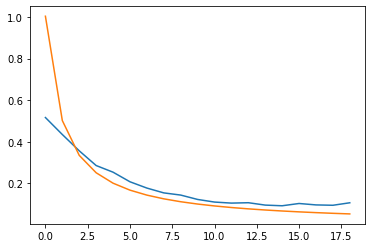

47766733223.26655 7978909317.4099655 60192.71974053776


In [5]:
#input sfs, corrected raisd file, file prefix  

#fit demographic model
#print obs and exp sfs to figure
#print prefix, parameters, etc. to data file for alter concactenation
#filter raisd file for outliers



import dadi
from dadi import Numerics, PhiManip, Integration, Spectrum
import numpy as np
import os
import matplotlib.pyplot as plt
import dadi.DFE as DFE


def two_epoch(params, ns, pts):
    """
    Instantaneous size change some time ago.

    params = (nu,T)
    ns = (n1,)

    nu: Ratio of contemporary to ancient population size
    T: Time in the past at which size change happened (in units of 2*Na 
       generations) 
    n1: Number of samples in resulting Spectrum
    pts: Number of grid points to use in integration.
    """
    nu,T = params

    xx = Numerics.default_grid(pts)
    phi = PhiManip.phi_1D(xx)
    
    phi = Integration.one_pop(phi, xx, T, nu)

    fs = Spectrum.from_phi(phi, ns, (xx,))
    return fs


def three_epoch(params, ns, pts):
    """
    params = (nuB,nuF,TB,TF)
    ns = (n1,)

    nuB: Ratio of bottleneck population size to ancient pop size
    nuF: Ratio of contemporary to ancient pop size
    TB: Length of bottleneck (in units of 2*Na generations) 
    TF: Time since bottleneck recovery (in units of 2*Na generations) 

    n1: Number of samples in resulting Spectrum
    pts: Number of grid points to use in integration.
    """
    nuB,nuF,TB,TF = params

    xx = Numerics.default_grid(pts)
    phi = PhiManip.phi_1D(xx)

    phi = Integration.one_pop(phi, xx, TB, nuB)
    phi = Integration.one_pop(phi, xx, TF, nuF)

    fs = Spectrum.from_phi(phi, ns, (xx,))
    return fs


with open("../data/angsd_sfs/v5--LR--Crucero_Lagunitas_fold4_AT,AG,AC,TA,TG,TC,GA,GT,GC,CA,CT,CG_sfs.txt") as f:
#with open("../data/angsd_sfs/v5--LR--random1_Palmar_Chico_fold4_AT,AG,AC,TA,TG,TC,GA,GT,GC,CA,CT,CG_sfs.txt") as f:   
    sfs = f.readlines()[0].split()
    sfs = [float(s) for s in sfs]

with open("../data/angsd_sfs/v5--Teo--Crucero_Lagunitas_fold0_AT,TA,GC,CG_sfs.txt") as f:
    sel_sfs = f.readlines()[0].split()
    sel_sfs = [float(s) for s in sfs]


fs = dadi.Spectrum(np.round(sfs, 0))

sel_fs = dadi.Spectrum(np.round(sel_sfs, 0))

params = (1, 1, 1, 1)
ns = fs.sample_sizes
pts = [100]

my_extrap_func = Numerics.make_extrap_log_func(three_epoch)
model = my_extrap_func(params, ns, pts)

plt.plot(sfs[1:-1]/np.sum(sfs[1:-1]))
plt.plot(my_extrap_func(params, ns, pts))
plt.show()

ll_model = dadi.Inference.ll_multinom(model, fs)
theta = dadi.Inference.optimal_sfs_scaling(model, fs)


#lower_bound, upper_bound = [1e-4, 1e-4, 1e-4, 1e-4], [2e1, 2e1, 2, 2]
#p0 = dadi.Misc.perturb_params(params, lower_bound=lower_bound, upper_bound=upper_bound)
#dadi_opt = dadi.Inference.optimize_log(p0, fs, my_extrap_func, pts, verbose=1, maxiter=100, lower_bound=lower_bound, upper_bound=upper_bound)

p0 = dadi.Misc.perturb_params(params)
dadi_opt = dadi.Inference.optimize_log(p0, fs, my_extrap_func, pts, verbose=1, maxiter=100)

plt.plot(sfs[1:-1]/theta)
plt.plot(my_extrap_func(params, ns, pts)[1:-1])
plt.show()

ns = ns
reps = 10
bps = 10000

mu = 3e-8
nu_B, nu_A, T_B, T_R = dadi_opt
theta_sc = theta / sum(sfs)
N_0 = theta_sc/(4*mu)
N_A = N_0 / nu_A
N_B = nu_B * N_A

c = 1.6e-8
rho = 4*N_ref*c

print(f"{N_A} {N_B} {N_0}")

In [11]:


spectra = DFE.Cache1D(dadi_opt, ns, DFE.DemogSelModels.two_epoch, pts_l=pts, 
                      gamma_bounds=(1e-5, 500), gamma_pts=100, verbose=True,
                      mp=True)

sel_params = [0.2, 1000.]
lower_bound, upper_bound = [1e-3, 1e-2], [1, 50000.]


p0 = dadi.Misc.perturb_params(sel_params, lower_bound=lower_bound,
                              upper_bound=upper_bound)


popt = dadi.Inference.optimize_log(p0, sel_fs, spectra.integrate, pts=None,
                                   func_args=[DFE.PDFs.gamma, theta],
                                   lower_bound=lower_bound, upper_bound=upper_bound, 
                                   verbose=len(sel_params), maxiter=10, multinom=False)


popt


my_extrap_func = Numerics.make_extrap_log_func(DFE.DemogSelModels.two_epoch)
#model = my_extrap_func(popt, ns, pts)

popt

array([0.88044928, 0.01029516])

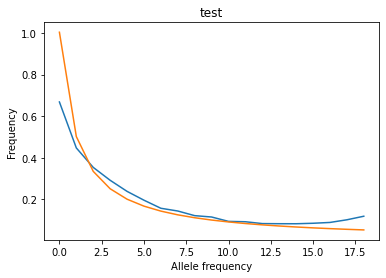

In [14]:
plt.plot(sfs[1:-1]/theta)
plt.plot(my_extrap_func(params, ns, pts)[1:-1])
plt.xlabel("Allele frequency") 
plt.ylabel("Frequency")
plt.title(f"{}")
plt.savefig(f'../figures/{}')


In [219]:
theta_sc

0.005646033111461046